# R C3X fidelity check

2019/1/6

origined by rum

---
In this code, two types of R-Toffoli gate are checked fidelity on real device

In [1]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

---
# 1. Get device

In [2]:
IBMQ.load_account()

/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Here to choose provider

In [3]:
## keio-internal device
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

### Define the backend device

In [4]:
device = provider.get_backend("ibmq_valencia")

---
# 2. Define circuit

### 2-1. Define R-Toffoli as function

---
### R-Toffoli_m
<img src="../img/RToffoli_m.png" />

In [5]:
## define RTof function
def RTof_m(qc, c1, c2, t):
    qc.ry(pi/4, t)
    qc.cx(c2, t)
    qc.ry(pi/4, t)
    qc.cx(c1, t)
    qc.ry(-pi/4, t)
    qc.cx(c2, t)
    qc.ry(-pi/4, t)

---
### R-Toffoli_ix
<img src="../img/RToffoli_ix.png" />

In [6]:
def RTof_ix(qc, c1, c2, t):
#     qc.h(t)
#     qc.t(t)
    qc.u2(pi/4, pi, t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
#     qc.tdg(t)
#     qc.h(t)
    qc.u2(0, 3*pi/4, t)

---
### Toffoli gate with one swap
<img src = "../img/Toffoli_SWAP.png" />

In [7]:
## Toffoli gate with one swap
def Toffoli_SWAP(circuit, control1,  control2, target):
    
    """
    c1, c2, t => c1, t, c2
    """
    
    circuit.h(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(control2, target)
    circuit.t(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(target, control2) ## SWAP
    circuit.cx(control2, target) ## SWAP
    circuit.t(control1)
    circuit.t(control2)
    circuit.cx(target ,control1)
    circuit.tdg(control1)
    circuit.h(control2)
    circuit.t(target)
    circuit.cx(target, control1)

### 2-2. Compose circuit

In [8]:
## define qubit label as num_qubits
num_qubits = len(device.configuration().gates[0].coupling_map)


## Define the list to store the circuit lists of each qubits of the processor
RTof_qc = []

## define init_list
init_list = [format(j, '03b') for j in range(8)]


## define qubit
c1, c2, targ = [0, 1, 2]

In [9]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    RTof_m(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[1])
    circuit.measure(qr[targ], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [10]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    RTof_ix(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[1])
    circuit.measure(qr[targ], cr[0])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [11]:
## repeat circuit definition for each init_list
for init in init_list:

    ## define circuit
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(3, "c")
    circuit = QuantumCircuit(qr, cr)

    ## Initialization
    if(init[0] == '1'):
        circuit.x(qr[c1])
    if(init[1] == '1'):
        circuit.x(qr[c2])
    if(init[2] == '1'):
        circuit.x(qr[int(targ)])

    ## R-Tof_m
    Toffoli_SWAP(circuit, qr[c1], qr[c2], qr[targ])
    
    ## insert barrier between gates and measurement
    circuit.barrier()

    ## measure the qubit
    circuit.measure(qr[c1], cr[2])
    circuit.measure(qr[c2], cr[0])
    circuit.measure(qr[targ], cr[1])

    ## Append the circuit to the init_list_qc list
    RTof_qc.append(circuit)

In [12]:
RTof_qc[0].draw()

---
# 3. Run on QASM simulator

### 3-1. Execution

In [13]:
## define simulator
simulator = Aer.get_backend("qasm_simulator")

## define shots
shots = 8192

## define repeat length
in_len = len(init_list)

## define job
job_sim = execute(RTof_qc, backend = simulator, shots = shots)
result_sim = job_sim.result()


## define the list to imidiately store the counts of the each circuit
## repeat # of each angle circuits times
counts_sim_m = [result_sim.get_counts(init) for init in range(in_len)]
counts_sim_ix = [result_sim.get_counts(init) for init in range(in_len, 2*in_len)]
counts_sim_swap = [result_sim.get_counts(init) for init in range(2*in_len, 3*in_len)]

In [14]:
print('counts_sim_m = ', counts_sim_m)

counts_sim_m =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


In [15]:
print('counts_sim_ix = ', counts_sim_ix)

counts_sim_ix =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


In [16]:
print('counts_sim_swap = ', counts_sim_swap)

counts_sim_swap =  [{'000': 8192}, {'001': 8192}, {'010': 8192}, {'011': 8192}, {'100': 8192}, {'101': 8192}, {'111': 8192}, {'110': 8192}]


### 3-2. Plot the result

In [17]:
## define length of repeat
input_len = len(counts_sim_m)
output_bin = [format(num, '03b') for num in range(8)]


sim_data_m = [[(counts_sim_m[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_data_ix = [[(counts_sim_ix[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]
sim_data_swaptof = [[(counts_sim_swap[inputvalue].get(outputvalue, 0))/shots for outputvalue in output_bin] for inputvalue in range(input_len)]

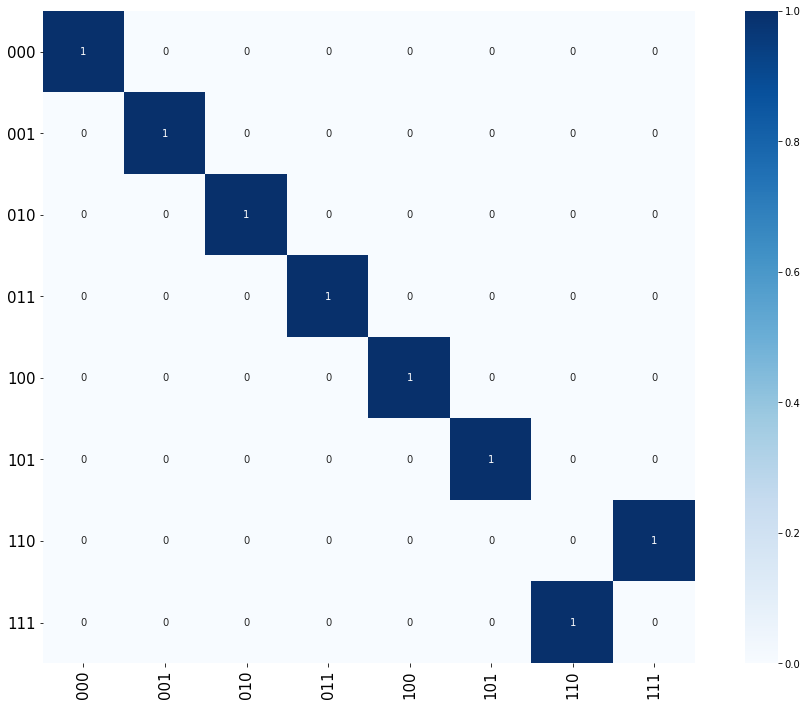

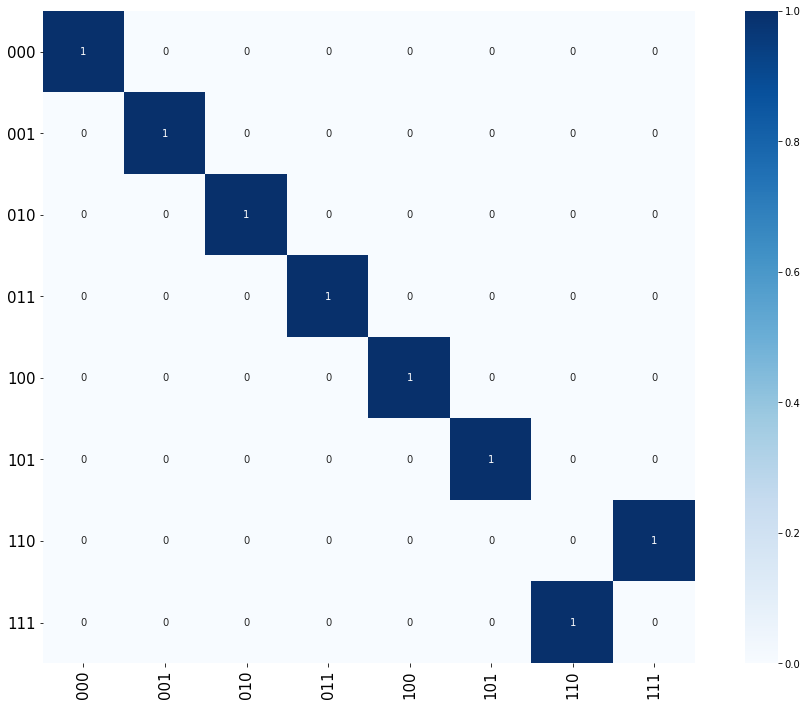

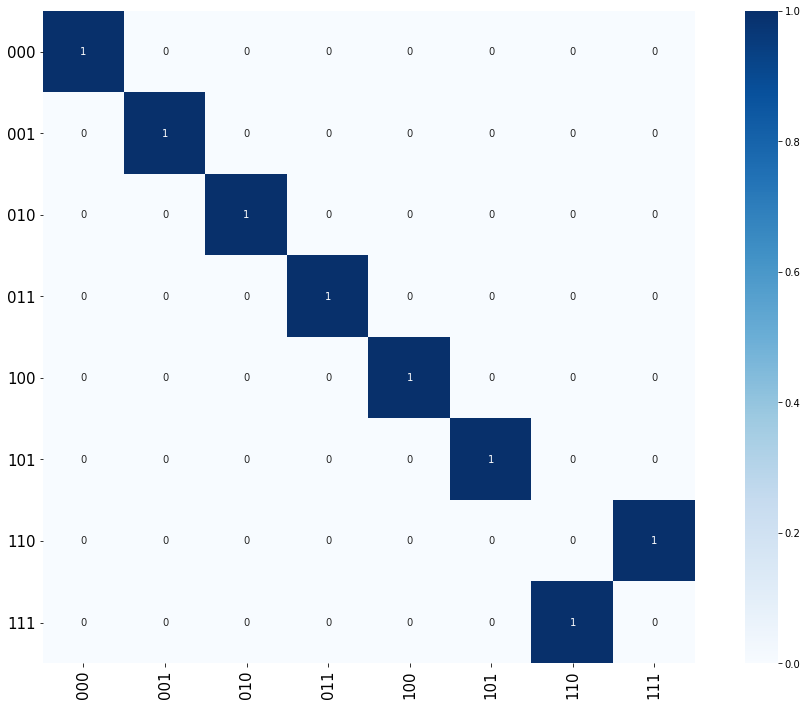

In [18]:
## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X

for sim_data in [sim_data_m, sim_data_ix, sim_data_swaptof]:
    ## set size
    fig,ax = plt.subplots(figsize=(18, 12))
    
    ## plot data
    sns.heatmap(sim_data, 
                vmin = 0.0,  ## define maximum value
                vmax=1.0,   ## defnie minimum value
                annot=True, ## show the numerical data
                square=True,  ## set heatmap to square shape
                cmap=plt.get_cmap('Blues') ## define the color
               )

    ## axis
    plt.xticks(length, 
               X, 
               rotation=90, 
               fontsize=15
              )
    plt.yticks(length, 
               Y, 
               rotation=0, 
               fontsize=15)
    
    plt.show()

---
# 4. Run on Realdevice

In [19]:
# backend_monitor(device)

ibmq_valencia
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 48
    backend_version: 1.0.3
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    sample_name: Giraffe
    uchannels_enabled: True
    conditional: False
    conditional_latency: []
    online_date: 2019-07-03T04:00:00+00:00
    acquisition_latency: []
    backend_name: ibmq_valencia
    meas_lo_range: [[6.791423281, 7.791423281], [6.564734703, 7.564734703], [6.709148181, 7.709148181], [6.637515922, 7.637515922], [6.484029338, 7.484029338]]
    n_registers: 1
    meas_levels: [0, 1]
    discriminators: ['linear_discriminator', 'quadratic_discriminator']
    coupling_map: [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
    max_shots: 8192
    meas_map: [[0, 1, 2, 3, 4]]
    description: 5 qubit device Valencia
    url: None
    u_channel_lo: [[{'scale': [1.0, 0.0], 'q': 1}], [{'scale': [1.0, 0.0], 'q': 0}], [{'sca

In [20]:
a_day = datetime(2020, 1, 6)
backend = provider.backends.ibmq_valencia
prop = backend.properties(datetime=a_day)

_qubit_key_list = list(prop._gates.get('u1').keys())

u2_error_20200101_list = [prop._gates.get('u2').get((0, )).get('gate_error')[0] for qubit in _qubit_key_list]
print('u2_error_20200101_list = ', u2_error_20200101_list)

u3_error_20200101_list = [prop._gates.get('u3').get((0, )).get('gate_error')[0] for qubit in _qubit_key_list]
print('u3_error_20200101_list = ', u3_error_20200101_list)

_cx_key_list = list(prop._gates.get('cx').keys())
cx_error_20200101_list = [prop._gates.get('cx').get(cx_connection).get('gate_error')[0] for cx_connection in _cx_key_list]
print('cx_error_20200101_list = ', cx_error_20200101_list)

u2_error_20200101_list =  [0.00040556182057519674, 0.00040556182057519674, 0.00040556182057519674, 0.00040556182057519674, 0.00040556182057519674]
u3_error_20200101_list =  [0.0008111236411503935, 0.0008111236411503935, 0.0008111236411503935, 0.0008111236411503935, 0.0008111236411503935]
cx_error_20200101_list =  [0.010759105929665974, 0.010759105929665974, 0.012100977655194717, 0.02036213132999834, 0.012100977655194717, 0.02036213132999834, 0.009046288507126687, 0.009046288507126687]


### 4-1. finding the qubit mapping list

In [21]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


In [22]:
## searching the qubit mapping list from coupling_map
#
#
import numpy as np
from collections import Counter
from copy import copy

## get qubit coupling_map from configuraion
conf=device.configuration()
coupling_map = conf.coupling_map


hub_list = []
adj_qubit_list=[]
qubit_mapping=[]

## finding hubs of mapping
counter = Counter(np.ravel(coupling_map))
for qubit, cnt in counter.most_common():
#     print(qubit, ":", cnt)
    if(cnt>=4):
        hub_list.append([qubit]) 

## finding the adjacency qubits of hub-qubit
for hub in hub_list:
    adj_list=[]
    for con in range(len(coupling_map)):
        if(coupling_map[con][0]==hub[0]):
            adj = coupling_map[con][1]
            
            ## append adjacency qubit
            adj_list.append(adj)
    adj_qubit_list.append([hub[0], adj_list])
# print(adj_qubit_list)

## sorting the arrangement
for hub in adj_qubit_list:
    for c1 in range(len(hub[1])):
        for c2 in range(len(hub[1])):
            if hub[1][c2] != hub[1][c1]:
                mapping = []
                mapping.append(hub[1][c1])
                mapping.append(hub[1][c2])
                mapping.append(hub[0])
#                 print(mapping)
                
                qubit_mapping.append(mapping)
        
print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[0, 2, 1], [0, 3, 1], [2, 0, 1], [2, 3, 1], [3, 0, 1], [3, 2, 1], [1, 4, 3], [4, 1, 3]]


### 4-2. Define mitigation circuit

In [23]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [24]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a50ec88>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2247aa90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a517be0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a517d30>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a517940>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a5179b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a517898>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a51a198>]
['000', '001', '010', '011', '100', '101', '110', '111']


### 4-3. Execution

In [25]:
## define shots
shots = 8192

## define the lists to store job_id
job_id_list = []
cal_job_id_list = []

## repeat # of qubit_mapping times
for mapping in qubit_mapping:
    
    ## job for circuit execution
    job_exp = execute(RTof_qc,
                      backend = device, 
                      shots = shots,
                      initial_layout=mapping,
                      optimization_level = 0
                     )
    job_id_list.append(job_exp.job_id())
    print('sent the job', mapping)

    
    ## job for meas_cal
    cal_job = execute(meas_calibs, 
                    backend = device,
                    shots=shots,
                    initial_layout=mapping,
                    optimization_level=0
                    )
    cal_job_id_list.append(cal_job.job_id())
    print('sent the cal_job', mapping)
    
#     ## get results
#     result_exp = job_exp.result()
#     result_cal = cal_job.result()
    
#     result_exp_list.append(result_exp)
#     result_cal_exp_list.append(result_cal)

print('job_id_list = ', job_id_list)
print('cal_job_id_list = ', cal_job_id_list)

sent the job [0, 2, 1]
sent the cal_job [0, 2, 1]
sent the job [0, 3, 1]
sent the cal_job [0, 3, 1]
sent the job [2, 0, 1]
sent the cal_job [2, 0, 1]
sent the job [2, 3, 1]
sent the cal_job [2, 3, 1]
sent the job [3, 0, 1]
sent the cal_job [3, 0, 1]
sent the job [3, 2, 1]
sent the cal_job [3, 2, 1]
sent the job [1, 4, 3]
sent the cal_job [1, 4, 3]
sent the job [4, 1, 3]
sent the cal_job [4, 1, 3]
job_id_list =  ['5e12fa9888f06b001155b0c6', '5e12fa9f88f06b001155b0c9', '5e12faa388f06b001155b0ca', '5e12faa75879b80012ec8b7d', '5e12faac88f06b001155b0cc', '5e12fab239e9810012555efb', '5e12fab639e9810012555efc', '5e12fabb7272e100112de63f']
cal_job_id_list =  ['5e12fa9b5879b80012ec8b7c', '5e12faa1e7977f001127dcba', '5e12faa539e9810012555efa', '5e12faaa88f06b001155b0cb', '5e12faaf88f06b001155b0cd', '5e12fab45879b80012ec8b7f', '5e12fab906766d001137ca9c', '5e12fabeefb76e0011439074']


In [26]:
job_id_list =  ['5e12fa9888f06b001155b0c6', '5e12fa9f88f06b001155b0c9', '5e12faa388f06b001155b0ca', '5e12faa75879b80012ec8b7d', '5e12faac88f06b001155b0cc', '5e12fab239e9810012555efb', '5e12fab639e9810012555efc', '5e12fabb7272e100112de63f']
cal_job_id_list =  ['5e12fa9b5879b80012ec8b7c', '5e12faa1e7977f001127dcba', '5e12faa539e9810012555efa', '5e12faaa88f06b001155b0cb', '5e12faaf88f06b001155b0cd', '5e12fab45879b80012ec8b7f', '5e12fab906766d001137ca9c', '5e12fabeefb76e0011439074']

### 4-4. retrieve the job and get the result

In [27]:
        ## Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id, cal_job_id in zip(job_id_list, cal_job_id_list) :
    ## retrieve jobs
    retrieved_job = device.retrieve_job(job_id)
    retrieved_cal_job = device.retrieve_job(cal_job_id)
    print("jobs were retrieved")
    result_exp = retrieved_job.result()
    print("got exp result")
    result_cal_exp = retrieved_cal_job.result()
    print("got cal_exp result")
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp)
    result_cal_exp_list.append(result_cal_exp)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
jobs were retrieved
got exp result
got cal_exp result
[Result(backend_name='ibmq_valencia', backend_version='1.0.3', date=datetime.datetime(2019, 12, 26, 1, 25, 27, tzinfo=datetime.timezone.utc), execution_id='51605382-277e-11ea-afba-ac1f6b47c318', header=Obj(backend_name='ibmq_valencia', backend_version='1.0.3'), job_id='5e04069858c50e0012c33e6f', qobj_id='f3adbbe0-dc2f-41b2-b477-378375528768', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=7475, 0x1=273, 0x2=232, 0x3=37, 0x4=154, 0x5=13, 0x6=4, 0x7=4)), header=Obj(clbit_labels=[['c', 0], ['c', 1], ['c', 2]], creg_sizes=[['c', 3]], memory_slots

# Readout Error mitigation

The calibration matrix 

[[9.62402344e-01 4.11376953e-02 6.53076172e-02 3.66210938e-03
  5.32226562e-02 2.31933594e-03 3.66210938e-03 3.66210938e-04]
 [1.52587891e-02 9.38598633e-01 7.32421875e-04 7.33642578e-02
  1.70898438e-03 5.46875000e-02 2.44140625e-04 4.27246094e-03]
 [1.31835938e-02 6.10351562e-04 9.02709961e-01 3.71093750e-02
  8.54492188e-04 0.00000000e+00 5.22460938e-02 1.83105469e-03]
 [1.22070312e-04 1.34277344e-02 1.61132812e-02 8.65478516e-01
  0.00000000e+00 4.88281250e-04 1.22070312e-03 4.77294922e-02]
 [7.93457031e-03 1.22070312e-04 5.85937500e-03 2.44140625e-04
  9.16748047e-01 4.00390625e-02 6.98242188e-02 2.44140625e-03]
 [3.66210938e-04 5.85937500e-03 0.00000000e+00 8.91113281e-03
  1.44042969e-02 8.91235352e-01 1.83105469e-03 6.46972656e-02]
 [6.10351562e-04 0.00000000e+00 9.03320312e-03 6.10351562e-04
  1.26953125e-02 9.76562500e-04 8.57910156e-01 3.51562500e-02]
 [1.22070312e-04 2.44140625e-04 2.44140625e-04 1.06201172e-02
  3.66210938e-04 1.02539062e-02 1.3061

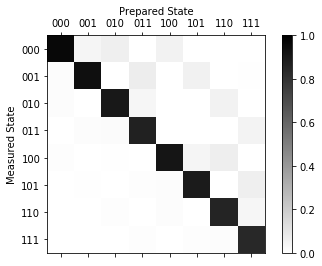

Average Measurement Fidelity: 0.897324 

The calibration matrix 

[[9.61791992e-01 3.88183594e-02 4.16259766e-02 1.83105469e-03
  4.45556641e-02 2.56347656e-03 1.95312500e-03 1.22070312e-04]
 [1.44042969e-02 9.42016602e-01 1.09863281e-03 4.84619141e-02
  9.76562500e-04 4.41894531e-02 1.22070312e-04 2.07519531e-03]
 [1.45263672e-02 6.10351562e-04 9.35058594e-01 4.02832031e-02
  4.88281250e-04 0.00000000e+00 4.94384766e-02 1.83105469e-03]
 [2.44140625e-04 1.20849609e-02 1.51367188e-02 9.01977539e-01
  0.00000000e+00 6.10351562e-04 7.32421875e-04 4.51660156e-02]
 [8.78906250e-03 3.66210938e-04 4.88281250e-04 0.00000000e+00
  9.25781250e-01 3.80859375e-02 3.73535156e-02 1.83105469e-03]
 [1.22070312e-04 5.98144531e-03 0.00000000e+00 1.22070312e-04
  1.47705078e-02 9.04296875e-01 6.10351562e-04 4.13818359e-02]
 [1.22070312e-04 0.00000000e+00 6.46972656e-03 2.44140625e-04
  1.30615234e-02 3.66210938e-04 8.96606445e-01 3.56445312e-02]
 [0.00000000e+00 1.22070312e-04 1.22070312e-04 7.08007812e-

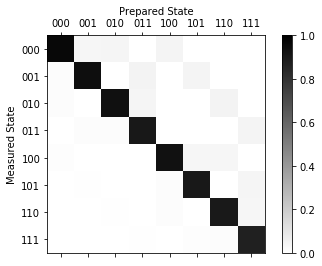

Average Measurement Fidelity: 0.917435 

The calibration matrix 

[[9.59472656e-01 6.79931641e-02 4.30908203e-02 3.05175781e-03
  4.85839844e-02 3.54003906e-03 1.83105469e-03 2.44140625e-04]
 [1.55029297e-02 9.03686523e-01 6.10351562e-04 4.01611328e-02
  8.54492188e-04 4.33349609e-02 0.00000000e+00 2.68554688e-03]
 [1.58691406e-02 1.83105469e-03 9.36889648e-01 6.90917969e-02
  7.32421875e-04 0.00000000e+00 4.98046875e-02 2.44140625e-03]
 [2.44140625e-04 1.86767578e-02 1.09863281e-02 8.78906250e-01
  0.00000000e+00 1.58691406e-03 6.10351562e-04 4.32128906e-02]
 [8.05664062e-03 1.34277344e-03 4.88281250e-04 1.22070312e-04
  9.19921875e-01 6.11572266e-02 4.54101562e-02 2.68554688e-03]
 [2.44140625e-04 6.22558594e-03 0.00000000e+00 1.34277344e-03
  1.23291016e-02 8.75122070e-01 1.22070312e-03 4.41894531e-02]
 [6.10351562e-04 0.00000000e+00 7.81250000e-03 4.88281250e-04
  1.73339844e-02 1.22070312e-03 8.90869141e-01 6.78710938e-02]
 [0.00000000e+00 2.44140625e-04 1.22070312e-04 6.83593750e-

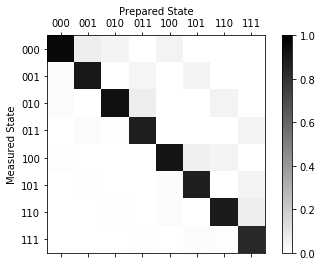

Average Measurement Fidelity: 0.900192 

The calibration matrix 

[[9.65454102e-01 6.90917969e-02 4.66308594e-02 4.02832031e-03
  4.78515625e-02 3.17382812e-03 2.19726562e-03 0.00000000e+00]
 [1.56250000e-02 9.12841797e-01 3.66210938e-04 4.30908203e-02
  8.54492188e-04 4.66308594e-02 0.00000000e+00 1.95312500e-03]
 [9.88769531e-03 6.10351562e-04 9.31274414e-01 6.68945312e-02
  3.66210938e-04 0.00000000e+00 4.67529297e-02 2.80761719e-03]
 [1.22070312e-04 1.09863281e-02 1.31835938e-02 8.77685547e-01
  0.00000000e+00 3.66210938e-04 1.09863281e-03 4.39453125e-02]
 [8.78906250e-03 7.32421875e-04 7.32421875e-04 0.00000000e+00
  9.23706055e-01 6.76269531e-02 4.34570312e-02 4.27246094e-03]
 [1.22070312e-04 5.73730469e-03 0.00000000e+00 6.10351562e-04
  1.55029297e-02 8.72802734e-01 4.88281250e-04 3.96728516e-02]
 [0.00000000e+00 0.00000000e+00 7.69042969e-03 9.76562500e-04
  1.14746094e-02 6.10351562e-04 8.90625000e-01 6.44531250e-02]
 [0.00000000e+00 0.00000000e+00 1.22070312e-04 6.71386719e-

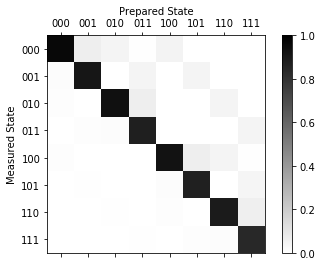

Average Measurement Fidelity: 0.902161 

The calibration matrix 

[[9.67651367e-01 5.04150391e-02 3.72314453e-02 2.07519531e-03
  5.34667969e-02 2.31933594e-03 2.19726562e-03 1.22070312e-04]
 [9.39941406e-03 9.28466797e-01 9.76562500e-04 3.64990234e-02
  8.54492188e-04 4.78515625e-02 1.22070312e-04 1.46484375e-03]
 [1.53808594e-02 8.54492188e-04 9.43115234e-01 4.60205078e-02
  1.09863281e-03 0.00000000e+00 4.80957031e-02 2.68554688e-03]
 [3.66210938e-04 1.36718750e-02 1.13525391e-02 9.08569336e-01
  0.00000000e+00 8.54492188e-04 7.32421875e-04 4.57763672e-02]
 [7.08007812e-03 1.22070312e-04 4.88281250e-04 0.00000000e+00
  9.16992188e-01 4.24804688e-02 4.68750000e-02 1.70898438e-03]
 [0.00000000e+00 6.22558594e-03 0.00000000e+00 2.44140625e-04
  1.26953125e-02 8.92822266e-01 2.44140625e-04 4.44335938e-02]
 [1.22070312e-04 0.00000000e+00 6.71386719e-03 3.66210938e-04
  1.46484375e-02 6.10351562e-04 8.89648438e-01 3.79638672e-02]
 [0.00000000e+00 2.44140625e-04 1.22070312e-04 6.22558594e-

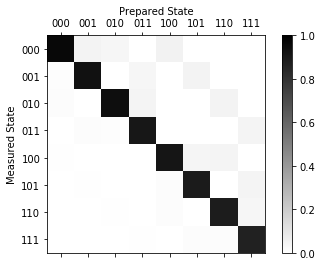

Average Measurement Fidelity: 0.914139 

The calibration matrix 

[[9.61914062e-01 4.83398438e-02 6.46972656e-02 4.39453125e-03
  5.20019531e-02 2.92968750e-03 3.78417969e-03 1.22070312e-04]
 [1.06201172e-02 9.28710938e-01 1.58691406e-03 6.54296875e-02
  4.88281250e-04 4.77294922e-02 0.00000000e+00 4.02832031e-03]
 [1.18408203e-02 2.44140625e-04 9.07592773e-01 4.30908203e-02
  9.76562500e-04 0.00000000e+00 4.98046875e-02 3.41796875e-03]
 [2.44140625e-04 1.08642578e-02 1.11083984e-02 8.71337891e-01
  0.00000000e+00 6.10351562e-04 3.66210938e-04 4.65087891e-02]
 [1.45263672e-02 7.32421875e-04 2.92968750e-03 1.22070312e-04
  9.20043945e-01 4.62646484e-02 6.35986328e-02 3.66210938e-03]
 [6.10351562e-04 1.11083984e-02 2.44140625e-04 2.80761719e-03
  1.28173828e-02 8.92089844e-01 7.32421875e-04 6.46972656e-02]
 [2.44140625e-04 0.00000000e+00 1.17187500e-02 7.32421875e-04
  1.33056641e-02 6.10351562e-04 8.68530273e-01 4.00390625e-02]
 [0.00000000e+00 0.00000000e+00 1.22070312e-04 1.20849609e-

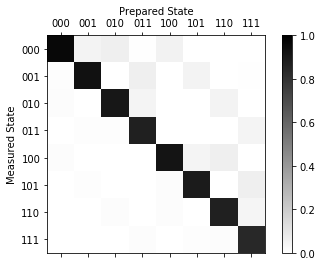

Average Measurement Fidelity: 0.898468 

The calibration matrix 

[[9.57763672e-01 4.80957031e-02 6.12792969e-02 2.44140625e-03
  4.69970703e-02 3.17382812e-03 2.19726562e-03 1.22070312e-04]
 [1.11083984e-02 9.26513672e-01 4.88281250e-04 5.77392578e-02
  1.22070312e-03 4.45556641e-02 0.00000000e+00 4.51660156e-03]
 [1.67236328e-02 3.66210938e-04 9.15771484e-01 4.33349609e-02
  6.10351562e-04 2.44140625e-04 4.56542969e-02 2.92968750e-03]
 [3.66210938e-04 1.25732422e-02 9.15527344e-03 8.80737305e-01
  0.00000000e+00 8.54492188e-04 1.46484375e-03 4.12597656e-02]
 [1.35498047e-02 7.32421875e-04 1.09863281e-03 3.66210938e-04
  9.25537109e-01 4.58984375e-02 6.10351562e-02 2.19726562e-03]
 [4.88281250e-04 1.14746094e-02 0.00000000e+00 1.46484375e-03
  1.02539062e-02 8.93554688e-01 7.32421875e-04 5.74951172e-02]
 [0.00000000e+00 0.00000000e+00 1.13525391e-02 1.22070312e-03
  1.51367188e-02 1.09863281e-03 8.76098633e-01 8.81347656e-02]
 [0.00000000e+00 2.44140625e-04 8.54492188e-04 1.26953125e-

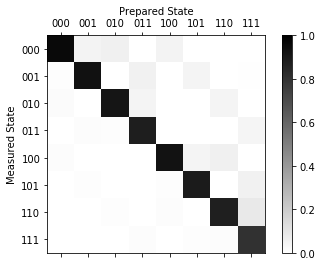

Average Measurement Fidelity: 0.897415 

The calibration matrix 

[[9.51538086e-01 6.48193359e-02 4.65087891e-02 4.76074219e-03
  4.12597656e-02 3.05175781e-03 1.46484375e-03 1.22070312e-04]
 [1.74560547e-02 9.07592773e-01 4.88281250e-04 5.07812500e-02
  7.32421875e-04 4.08935547e-02 0.00000000e+00 3.90625000e-03]
 [1.57470703e-02 8.54492188e-04 9.26025391e-01 6.31103516e-02
  1.34277344e-03 1.22070312e-04 4.57763672e-02 2.56347656e-03]
 [1.22070312e-04 1.12304688e-02 1.55029297e-02 8.71215820e-01
  0.00000000e+00 1.22070312e-03 1.34277344e-03 3.55224609e-02]
 [1.42822266e-02 9.76562500e-04 4.88281250e-04 0.00000000e+00
  9.25659180e-01 6.75048828e-02 4.83398438e-02 3.41796875e-03]
 [1.22070312e-04 1.39160156e-02 0.00000000e+00 1.09863281e-03
  1.61132812e-02 8.73901367e-01 1.22070312e-03 9.11865234e-02]
 [7.32421875e-04 1.22070312e-04 1.08642578e-02 3.66210938e-04
  1.45263672e-02 9.76562500e-04 8.86230469e-01 5.76171875e-02]
 [0.00000000e+00 4.88281250e-04 1.22070312e-04 8.66699219e-

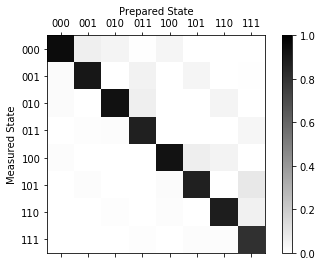

Average Measurement Fidelity: 0.893478 



In [28]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp, state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [59]:
## define the list to store 
mitigated_m_list = []
mitigated_ix_list = []
mitigated_swaptof_list = []

## define repeat length
in_len = len(init_list)

## repeat (num_qubits) times
for result_exp, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    
    ## get measurement error mitigated result
    mitigated_results = meas_filter.apply(result_exp)
    mitigated_m_counts = [mitigated_results.get_counts(init) for init in range(in_len)]
    mitigated_ix_counts = [mitigated_results.get_counts(init) for init in range(in_len, 2*in_len)]
    mitigated_swaptof_counts = [mitigated_results.get_counts(init) for init in range(2*in_len, 3*in_len)]
    
    ## Append mitigated_counts to mitigated_list
    mitigated_m_list.append(mitigated_m_counts)
    mitigated_ix_list.append(mitigated_ix_counts)
    mitigated_swaptof_list.append(mitigated_swaptof_counts)

### Show the mitigated counts

In [60]:
print("mitigated_m_counts = ", mitigated_m_list, "\n")
print("mitigated_ix_counts = ", mitigated_ix_list, "\n")
print("mitigated_swaptof_counts = ", mitigated_swaptof_list, "\n")

mitigated_m_counts =  [[{'101': 7.723083048437818, '111': 2.2276879744657347, '010': 141.68242632481864, '001': 160.92701964716295, '000': 7744.425349372783, '011': 35.8823011267269, '110': 5.919549383006165e-14, '100': 99.13213250560537}, {'001': 7505.5937156946575, '000': 502.29709294908156, '011': 52.10706282862713, '101': 80.68719554856239, '110': 2.0436429596494357, '100': 7.802798214948057, '010': 41.468491804474574}, {'001': 127.10348789773303, '000': 133.18726756425326, '011': 70.30580104932639, '101': 5.831968886765501e-14, '111': 105.52721740224254, '010': 7755.876226086694}, {'001': 9.301978365728031, '000': 60.15266124843223, '011': 7838.628482413112, '110': 86.6055662603286, '010': 197.3113117141949}, {'101': 55.64833105656586, '111': 171.26848530180047, '010': 2.6526392182133014, '001': 0.17102701578455948, '000': 23.185493827947543, '011': 2.018907259971115, '110': 2.5102455674143953, '100': 7934.544870752304}, {'101': 7837.245019283884, '111': 21.355769450799357, '010':

### post data processing

In [16]:
mitigated_m_counts =  [[{'101': 7.723083048437818, '111': 2.2276879744657347, '010': 141.68242632481864, '001': 160.92701964716295, '000': 7744.425349372783, '011': 35.8823011267269, '110': 5.919549383006165e-14, '100': 99.13213250560537}, {'001': 7505.5937156946575, '000': 502.29709294908156, '011': 52.10706282862713, '101': 80.68719554856239, '110': 2.0436429596494357, '100': 7.802798214948057, '010': 41.468491804474574}, {'001': 127.10348789773303, '000': 133.18726756425326, '011': 70.30580104932639, '101': 5.831968886765501e-14, '111': 105.52721740224254, '010': 7755.876226086694}, {'001': 9.301978365728031, '000': 60.15266124843223, '011': 7838.628482413112, '110': 86.6055662603286, '010': 197.3113117141949}, {'101': 55.64833105656586, '111': 171.26848530180047, '010': 2.6526392182133014, '001': 0.17102701578455948, '000': 23.185493827947543, '011': 2.018907259971115, '110': 2.5102455674143953, '100': 7934.544870752304}, {'101': 7837.245019283884, '111': 21.355769450799357, '010': 2.162081413426345e-14, '001': 8.815158699068425, '000': 14.485050015903406, '011': 0.45398013297900747, '110': 88.80640828918544, '100': 220.83861412817956}, {'101': 0.46338894236689543, '111': 7747.357885935851, '110': 148.85253449022883, '100': 155.6016996915967, '010': 139.7244909405519}, {'011': 110.57756754168592, '101': 226.4566540444009, '111': 145.7181587039334, '110': 7709.247619707776, '010': 2.7096033007413235e-09}], [{'001': 311.10906372458544, '000': 7693.081615788613, '011': 32.445583809865475, '101': 3.7584106384927765, '111': 2.7006799662561773, '100': 99.21472191391813, '010': 49.689924158267374}, {'001': 7551.807694876146, '000': 465.6221901148726, '011': 40.9558367491971, '101': 94.5350961887082, '110': 2.716441649273552, '100': 6.764273459514305, '010': 29.598466962288246}, {'001': 38.84424060935646, '000': 246.66095429522014, '011': 106.05594849476535, '101': 1.9958644112416657e-13, '111': 89.921526238392, '010': 7710.517330362269}, {'001': 58.51567061181374, '000': 45.58005877748019, '011': 7718.951705372651, '101': 0.5167563406184646, '111': 5.200155325741978e-12, '110': 111.76026085208272, '010': 256.6755480453491}, {'001': 3.186263937231334, '000': 61.09168587137072, '011': 2.7016743063632692e-12, '101': 69.56438778068377, '111': 115.5508784516873, '100': 7942.606783959087, '010': 5.013822148257352e-12}, {'001': 121.6871944312054, '000': 3.72281829435353, '101': 7726.365393125492, '110': 115.81379955740728, '100': 224.4107945915445, '010': 2.1105621590689072e-15}, {'001': 3.149365558363992e-12, '011': 1.3908534379811714e-11, '101': 6.073581518693089, '111': 7664.417043817533, '110': 219.6759432902361, '100': 178.61139892981456, '010': 123.2220324437052}, {'001': 4.6805123877946386e-11, '000': 2.0678163334676797e-11, '011': 123.05951245933196, '101': 119.9207397685936, '111': 133.73320542633226, '110': 7742.028311596121, '100': 73.25823075039878}], [{'101': 2.183342186226987, '111': 3.179180269173913, '010': 56.636697904377094, '001': 93.00455600566605, '000': 7887.267374895495, '011': 35.92422469626513, '110': 0.6121354059415621, '100': 113.19248863685499}, {'001': 7987.567717451082, '000': 60.18038542984107, '011': 2.582836288594903e-13, '101': 117.80162871718497, '111': 8.220326004095002e-14, '100': 3.1918472856093394e-13, '010': 26.45026840189085}, {'101': 3.208398173873417e-15, '111': 107.19696442214388, '010': 7796.294028450298, '001': 53.83195710076272, '000': 109.07634025063666, '011': 106.19001975188141, '110': 19.410690024275738, '100': 9.85431354572075e-16}, {'001': 124.29381514293578, '000': 50.15010534359254, '011': 7905.091567209155, '111': 3.768507439899485, '110': 108.6960048645557, '100': 2.2904436708239635e-12}, {'001': 9.7192612031477e-12, '000': 235.01687680918857, '011': 8.530375949881985e-12, '101': 74.0057476080814, '111': 109.74162671305231, '100': 7773.235748869732, '010': 8.177073384726952e-12}, {'001': 326.159589561689, '011': 2.5003960145803542e-11, '101': 7766.707201336154, '111': 1.658425052340786e-10, '110': 99.13320910200828}, {'101': 8.477977590253683e-10, '111': 7814.642890194776, '010': 88.93357467702904, '001': 5.1446125849502475e-11, '000': 5.778439733619711e-11, '011': 156.71556629390176, '110': 1.043576213639522e-09, '100': 131.7079688322927}, {'001': 7.568213279602374, '011': 100.00743967496894, '101': 184.93240971384895, '111': 55.86511250744707, '110': 7718.832583759427, '100': 4.2090245193311356e-10, '010': 124.79424106429897}], [{'101': 7.574769700293172, '111': 2.002847703931459, '010': 89.24367562145893, '001': 324.28142212750106, '000': 7581.47892841714, '011': 23.06258915815175, '110': 2.583564026896444, '100': 161.77220324462763}, {'101': 114.98342276367298, '111': 3.2394334610608144e-15, '010': 17.672084014807997, '001': 7877.3806920694105, '000': 111.58522188204523, '011': 64.789158861647, '110': 7.0305089874822535e-16, '100': 5.589420408416477}, {'001': 40.295943041706124, '000': 156.68070761498413, '011': 137.5962698115464, '111': 115.10005077022367, '110': 9.140432053673628, '010': 7733.186596707866}, {'001': 72.78494947023398, '000': 43.0773441871847, '011': 7972.03014954926, '101': 9.150337930939612e-12, '111': 5.323768355612903, '110': 98.78378843797121, '100': 8.647065593940517e-12}, {'001': 14.81822606228727, '000': 294.63749566736016, '011': 1.5573147751826028e-11, '101': 81.36084605841803, '111': 111.98790610522313, '100': 7689.195526106808, '010': 3.792186833648237e-12}, {'001': 406.23825077291093, '101': 7690.771523586338, '111': 4.4286986630257344e-11, '110': 94.9902256405345, '100': 2.5839785371492825e-10}, {'101': 3.877273271157379, '111': 7614.947331488338, '010': 103.1258686937649, '001': 3.549280437635519, '000': 4.781332500290766, '011': 289.3197479868124, '110': 24.042149015624865, '100': 148.35701660637628}, {'001': 5.767417668388091, '011': 130.70991264174617, '101': 180.2331807632318, '111': 104.96360634312403, '110': 7534.778508402861, '010': 235.54737418064886}], [{'101': 1.2913332798873987, '111': 1.9362184816102157, '010': 83.11261476562422, '001': 261.76719670208416, '000': 7722.726701732027, '011': 31.432737370468125, '110': 1.2558049527859834, '100': 88.47739271551379}, {'001': 7811.7353062007505, '000': 263.99791149280844, '101': 87.25789583060211, '110': 0.3186447651562563, '100': 4.443646007523948, '010': 24.24659570315905}, {'001': 43.708373008297336, '000': 135.43872879071296, '011': 116.96547849775246, '111': 97.2673475095876, '110': 4.645275321086412e-13, '100': 2.8188118072342006e-14, '010': 7798.620072193648}, {'001': 294.595587113723, '000': 49.526164467427336, '011': 7624.899438920003, '110': 99.15676161850337, '100': 4.013810632605072e-14, '010': 123.82204788034595}, {'101': 67.27786143343911, '111': 125.55111988549568, '010': 4.354511190648655e-12, '001': 2.083630225581196, '000': 87.55778220278144, '011': 3.63857097121327e-12, '110': 1.8663301264675025e-11, '100': 7909.529606252676}, {'001': 65.97573358749953, '011': 7.653747114203993e-11, '101': 7878.604271451933, '111': 8.42245080838153e-10, '110': 98.66298281739671, '100': 148.75701214243904, '010': 8.035007855075499e-12}, {'011': 1.1312763725471414e-10, '101': 80.12495706728475, '111': 7641.518707515135, '110': 203.59847335291175, '100': 141.7641922365363, '010': 124.99366982804192}, {'011': 107.6469715656731, '101': 138.5832464106409, '111': 44.53321898273392, '110': 7901.23656303991, '100': 1.1987558205962857e-09}], [{'101': 2.5868994257995017, '111': 2.711670948549183e-15, '010': 102.86100054111685, '001': 257.62634981315136, '000': 7728.496681196305, '011': 60.54888544053476, '110': 6.528360751295592e-15, '100': 39.880183583092496}, {'101': 51.01551978835254, '111': 1.9014698023593828, '010': 53.635899032802435, '001': 7735.326667775525, '000': 278.71262311742566, '011': 70.16595705195745, '110': 1.2418634315762374, '100': 1.9705374484924043e-16}, {'001': 86.59680511947224, '000': 137.920405567894, '011': 135.7742487765994, '101': 4.945281190842435e-12, '111': 93.86982685894982, '010': 7737.838713677374}, {'101': 1.1920819881347175e-11, '111': 4.8790462691067696e-11, '010': 160.01198354753066, '001': 87.83615719104661, '000': 101.4833611693032, '011': 7759.216188722862, '110': 83.45230936919421, '100': 2.570204736974252e-12}, {'001': 8.204614365394848, '000': 55.79099093974192, '101': 115.90118369326832, '111': 134.21379967897124, '110': 1.1346856166791729e-11, '100': 7877.889411322612, '010': 3.640030578387979e-13}, {'001': 75.22580030465913, '011': 3.444542397954741e-15, '101': 7813.024340686091, '111': 41.63712938307115, '110': 96.71663131955816, '100': 165.396098306622, '010': 1.244510177662485e-13}, {'001': 3.924356363106443e-12, '011': 3.55220877941536e-11, '101': 5.221821925578459e-12, '111': 7716.263336375869, '110': 189.32599720209336, '100': 185.861649012881, '010': 100.54901740911677}, {'001': 11.01271987457717, '000': 3.1665324138825897, '011': 115.28365751161564, '101': 179.49601413407962, '111': 126.53260724140625, '110': 7719.430639602259, '100': 37.077829222178735}], [{'101': 1.144592233492947e-15, '111': 1.5332911521823083, '010': 54.809326062491266, '001': 144.71021161718556, '000': 7901.504639050922, '011': 32.43163030843247, '110': 0.21346264016639835, '100': 56.79743916861916}, {'101': 63.22285594692278, '111': 3.586076612526953e-15, '010': 53.405616304029174, '001': 7827.05273563819, '000': 163.88715495798883, '011': 71.07310029122736, '110': 0.7515371721178802, '100': 12.606999689524761}, {'001': 167.57056952478314, '000': 384.5640445717795, '011': 148.60676076154292, '111': 77.49890133990824, '110': 2.1587763846496466e-10, '010': 7413.759723801783}, {'001': 198.70582159547388, '000': 196.91424624197094, '011': 7610.889871226194, '110': 72.5279212138978, '100': 3.0767760301336766e-13, '010': 112.96213972249289}, {'001': 2.948381827311969e-13, '000': 83.50352647108974, '011': 6.653115857889529, '101': 120.29552291289082, '111': 116.21728456508461, '100': 7865.330550193062, '010': 3.2776682030392218e-12}, {'001': 105.1789194527267, '000': 8.144844076301613e-13, '011': 20.47341905155701, '101': 7751.226264354513, '111': 3.3897400803149772e-12, '110': 122.9242388748822, '100': 192.19715826631702}, {'001': 3.2935016799884955e-11, '011': 589.9860022800385, '101': 85.06201540854562, '111': 7103.1132900477, '110': 4.919382852167891e-10, '100': 375.4423858511976, '010': 38.396306411999234}, {'101': 256.01683569890645, '111': 151.56228202299934, '010': 62.14879334065705, '001': 2.832985723138424, '000': 8.20452585428538, '011': 68.12352934835253, '110': 7455.475605797986, '100': 187.63544221367465}], [{'001': 102.24609891352893, '000': 7959.70348247885, '011': 72.04482883338665, '101': 3.6136688123367153, '110': 4.110519731667303e-12, '100': 54.391920961883855, '010': 1.1072122304287349e-11}, {'001': 7943.673393918491, '000': 67.06283269439922, '011': 17.168846348010717, '101': 91.27763847942573, '110': 0.499900550375033, '100': 1.6175004036961738, '010': 70.69988760560166}, {'001': 36.084887938493374, '000': 113.07489109739019, '011': 170.13196484626718, '101': 24.566501275074156, '111': 113.46156444995817, '110': 4.6547058742130165e-12, '010': 7734.6801903928135}, {'001': 85.64275183519737, '000': 42.34941205038659, '011': 7940.634882570162, '101': 9.008232579300213, '110': 114.36472096495716, '100': 2.18108436042877e-13}, {'001': 21.629586315839653, '000': 564.2000842333324, '011': 1.3948446390278768, '101': 127.02686539581467, '111': 116.71528125039634, '100': 7361.033338165747}, {'001': 498.3801720935848, '000': 8.061119215539563, '101': 7596.106632094403, '110': 84.39429384516659, '010': 5.057782751423146}, {'000': 12.271735147838914, '011': 402.3596146187394, '101': 36.36494944053072, '111': 7431.065708011177, '110': 57.91650136483541, '100': 115.53180907430013, '010': 136.4896823425789}, {'101': 268.9920998804784, '111': 231.24011893355987, '010': 362.1495535034333, '001': 7.775197258945061, '000': 10.219134912367853, '011': 149.56346284495407, '110': 7039.518792452643, '100': 122.54164021361927}]] 
mitigated_ix_counts =  [[{'001': 30.55171918472974, '000': 7844.517481510227, '011': 61.79276126395958, '101': 1.1484029619446652, '111': 1.5362854420086665, '100': 106.91555229105931, '010': 145.53779734607127}, {'101': 115.2205008707361, '111': 1.909822126833216e-16, '010': 64.50938762380582, '001': 7778.625430874363, '000': 191.96676437042674, '011': 33.718362735323936, '110': 1.459336124165489e-16, '100': 7.959553525345442}, {'001': 105.546451765601, '000': 171.16167506114866, '011': 26.30792642300603, '111': 107.2483512267653, '010': 7781.735595523559}, {'000': 21.18047641556079, '011': 7943.692504197163, '110': 93.07288811639518, '100': 2.4287379832982348e-12, '010': 134.05413127105186}, {'101': 7.596501322430342, '111': 197.13146611750992, '110': 13.748075048027756, '100': 7973.523957512044, '010': 2.2703355058139484e-12}, {'001': 14.884557235660715, '000': 0.3620867795474017, '011': 1.4722262013476033, '101': 7886.570164723497, '111': 2.64821901518896, '110': 117.27172242586119, '100': 168.79102361889693}, {'000': 1.1803665331095034e-11, '111': 7813.647458755608, '110': 149.11073834756988, '100': 126.10173817687836, '010': 103.14006472578835}, {'001': 6.4775709144901e-11, '000': 8.309516236074444e-12, '011': 80.27514949324797, '101': 189.60304155482692, '111': 92.92525137387813, '110': 7829.196557581731}], [{'101': 4.932385076723337, '111': 0.23231301032522786, '010': 39.08230677226993, '001': 121.04045364551638, '000': 7892.28599378433, '011': 32.889628150881606, '110': 2.4493685617070493e-14, '100': 101.53691955995448}, {'101': 112.09439683813655, '111': 1.5975719011573908e-16, '010': 22.758927030764937, '001': 7733.01202239933, '000': 258.6330818120325, '011': 52.03080389233671, '110': 5.391466353227292e-16, '100': 13.47076802740033}, {'101': 4.659087035221149, '111': 111.7748685922606, '010': 7743.900811040408, '001': 45.43441067973833, '000': 218.2527301926006, '011': 67.97809245977211, '110': 2.9805625740945974e-13, '100': 8.344860176132118e-15}, {'001': 34.23510029327041, '000': 51.375230061640075, '011': 7752.647393329483, '101': 6.123531603254061e-13, '110': 118.40563414998074, '100': 4.973090539497687e-13, '010': 235.3366421656303}, {'001': 5.833349585821652, '000': 73.38029828509724, '101': 29.220147922421464, '111': 115.78381803446612, '110': 1.1809534312913136e-10, '100': 7967.782386172095}, {'001': 122.47409252398981, '000': 8.529344336353391, '101': 7702.89243702091, '110': 129.2631802808583, '100': 228.84094583789818, '010': 1.2678395117614316e-12}, {'001': 9.483140005801734e-11, '011': 1.4173314203191085e-09, '101': 6.534798656728297e-10, '111': 7718.768590181794, '110': 225.59463164410468, '100': 140.19377301229972, '010': 107.4430051596513}, {'101': 141.7281086565427, '111': 124.31309171751978, '010': 6.717670387510002e-10, '001': 1.5743409679947968e-11, '000': 1.203834966899301e-11, '011': 130.29415455956493, '110': 7725.311364041779, '100': 70.35328102389485}], [{'001': 80.64680501920384, '000': 7872.064468977889, '011': 20.805368275743003, '101': 10.194222076288982, '111': 1.8584325300987405, '100': 155.52630820262505, '010': 50.90439491815199}, {'101': 139.84263803514355, '111': 1.1199974622247375, '010': 42.058043376729074, '001': 7946.939280342763, '000': 35.49632693456551, '011': 20.292282118798866, '110': 1.470998311854843, '100': 4.780433417920528}, {'001': 56.986868811264394, '000': 88.20038930604125, '011': 45.95982777197701, '111': 107.18757799649518, '110': 5.626836887054343e-13, '100': 0.7477205184396981, '010': 7892.917615595782}, {'001': 151.86701467791042, '000': 54.154359796204666, '011': 7879.3770339875055, '101': 2.945467214045521e-12, '111': 12.359483051558811, '110': 94.24210848677197, '010': 4.89245105372686e-11}, {'001': 1.6791959749767882e-11, '000': 233.15822062055963, '011': 2.270908027596219e-11, '101': 4.123580686979378e-11, '111': 130.61762005350798, '100': 7828.224159326074}, {'001': 294.8074738223892, '000': 1.972726317413046e-11, '101': 7824.127285388718, '110': 73.06524078910917, '010': 1.97638508779462e-11}, {'001': 3.29729642611775e-11, '011': 167.2759006694434, '101': 1.0096028691349369e-09, '111': 7713.0839955133315, '110': 1.4106351048736458e-10, '100': 177.59373588544963, '010': 134.0463679306906}, {'001': 2.3334490098178162, '011': 117.29919306328354, '101': 240.1654344953989, '111': 170.30727390707696, '110': 7498.580050094811, '100': 4.353288152264452e-10, '010': 163.31459942920574}], [{'101': 5.155103132953795, '111': 5.572298416511546, '010': 72.45827161797791, '001': 208.8454609354621, '000': 7734.725008921268, '011': 25.699768011318266, '110': 2.7913594338035908, '100': 136.75272953070427}, {'101': 114.51476242149141, '111': 3.790762124230955e-15, '010': 15.51620964412377, '001': 7974.988469608193, '000': 35.56222497454032, '011': 46.643594786804655, '110': 0.5705637150511479, '100': 4.204174849795146}, {'001': 59.92482418190461, '000': 129.33712749230108, '011': 111.38649951619031, '111': 103.70353954415364, '100': 4.33098698925965, '010': 7783.317022276194}, {'001': 52.63846365819579, '000': 34.99073744677618, '011': 7972.242191873482, '101': 0.7055515174490324, '111': 6.938488842108751, '110': 122.96697606127736, '100': 1.5175906007117612}, {'001': 6.666105589639383, '000': 298.00283699757574, '011': 3.1311717541698814e-12, '101': 77.36584760204518, '111': 104.92324679379666, '100': 7705.041963016961, '010': 1.2348262061305515e-12}, {'001': 332.0520719539017, '000': 3.9857270461077965, '101': 7766.827823418487, '111': 5.303819595970857e-11, '110': 89.13437758133115, '100': 1.417050049350166e-10}, {'101': 2.6329078973868267e-13, '111': 7619.1694706327935, '010': 114.05217844083604, '001': 4.205135321543927, '000': 7.92824916951604e-14, '011': 268.1362090170877, '110': 20.917499361144344, '100': 165.51950722659492}, {'011': 106.88977569073091, '101': 126.29480158403372, '111': 85.67446856937227, '110': 7667.1368199021135, '100': 1.0766051711308794e-09, '010': 206.00413425295972}], [{'001': 127.60810309221549, '000': 7841.568856979901, '011': 34.449128956400685, '101': 5.320852222859726, '111': 0.5359116369795909, '100': 101.46771316799274, '010': 81.04943394365189}, {'101': 91.14090876962628, '111': 1.3833796304665857e-14, '010': 35.25332463073937, '001': 7910.433998295012, '000': 140.7333165518257, '011': 11.007079132484247, '110': 0.34356437707966303, '100': 3.0878082432327023}, {'001': 45.923510494339624, '000': 152.47693049068036, '011': 66.01661280524482, '101': 1.108112326940816e-12, '111': 105.16445155154737, '010': 7822.418494658195}, {'101': 0.10410189655130593, '111': 4.593989813941098e-12, '010': 147.23552450537377, '001': 349.1379519747095, '000': 31.55088028911692, '011': 7560.138164813587, '110': 103.83337652065725, '100': 3.752584113131223e-13}, {'001': 4.007421652819313e-12, '000': 23.389139785543556, '101': 65.38948529255323, '111': 99.77221503223751, '110': 2.0194199594193675e-10, '100': 8003.449159889455, '010': 1.8322873451240458e-11}, {'001': 82.34954845490964, '011': 5.510245887046558e-12, '101': 7867.819766777281, '111': 6.133075463928692e-11, '110': 81.24971086828968, '100': 160.58097389945186, '010': 2.8774599698137364e-12}, {'001': 5.643193601035233, '011': 2.730430177640063e-14, '101': 93.5533779420592, '111': 7663.906856028149, '110': 162.02872208653906, '100': 170.74654671934306, '010': 96.12130362287397}, {'001': 8.988862154542205e-11, '011': 71.0363901845575, '101': 144.70909993192566, '111': 51.45080987143379, '110': 7924.80370001318}], [{'001': 165.69756530634663, '000': 7906.775818257488, '011': 33.86234089192959, '111': 1.8026669114302025, '110': 6.964101604417516e-16, '010': 83.86160863280588}, {'101': 65.72714880087804, '111': 0.03134979325282176, '010': 50.38322532645945, '001': 7828.228147426489, '000': 137.90015649720587, '011': 109.39159057524222, '110': 0.29192185594731224, '100': 0.04645972452573216}, {'001': 117.16646778654597, '000': 125.02749272255357, '011': 85.5967087869831, '111': 64.42555405807386, '110': 5.362460314560686e-10, '100': 1.9623618518926802e-10, '010': 7799.783776645154}, {'101': 1.123703619032839e-11, '111': 3.6166014722393246e-11, '010': 99.55971123928715, '001': 94.16752198747137, '000': 111.54772134562671, '011': 7794.791002861867, '110': 91.9340425656978, '100': 1.4352515486856787e-12}, {'101': 114.65235315335937, '111': 117.91983446250693, '010': 1.905485318143274e-16, '001': 5.8948482749159625, '000': 62.654156857581675, '011': 2.805381257659368, '110': 5.342631176873114e-14, '100': 7888.073425993977}, {'001': 64.37393222642022, '011': 3.514035046910732e-13, '101': 7790.170722619407, '111': 15.647346626281855, '110': 161.00342550860594, '100': 160.80457301928908, '010': 1.1342238208075641e-13}, {'000': 9.40736268038971e-13, '101': 2.514699586154353e-13, '111': 7768.690927062651, '110': 143.33768128609398, '100': 206.55457123869215, '010': 73.41682041257702}, {'011': 152.23513577768153, '101': 222.84368902143487, '111': 134.35915486948855, '110': 7613.799007796975, '100': 68.76301253444034}], [{'101': 2.8166089040394104, '111': 2.1546824112254892e-16, '010': 43.85030823528566, '001': 175.95430605894285, '000': 7882.471957978722, '011': 36.77502910664716, '110': 5.337087430141439, '100': 44.79470228622001}, {'001': 7903.075472040788, '000': 128.3146945945608, '011': 63.54718598514941, '101': 53.644821018952015, '110': 2.4914082760207386, '100': 1.7348100771458945, '010': 39.191608007384026}, {'001': 181.33162047952857, '000': 322.79299336717713, '011': 151.723995769628, '101': 2.6230293707473623e-12, '111': 109.06418504455473, '010': 7427.087205339127}, {'001': 201.8140897418761, '000': 203.5982037042608, '011': 7611.386708609677, '110': 87.10493200635194, '100': 1.944786454273484e-12, '010': 88.09606593788249}, {'000': 119.35902748750658, '011': 4.048920623808026, '101': 148.7267908203892, '111': 133.553131989599, '100': 7786.312129078727, '010': 4.132007155053033e-12}, {'101': 7890.97346825087, '111': 1.474418369239922e-11, '010': 0.781249943736317, '001': 66.66863073376301, '000': 3.2384120705588965e-13, '011': 22.29003092275695, '110': 151.6119989127838, '100': 59.6746212360739}, {'000': 9.664083457650053e-10, '011': 316.50289688775956, '101': 1.8201679204192242e-09, '111': 7533.518674720749, '100': 328.3203677324021, '010': 13.658060675682592}, {'101': 304.04260097678934, '111': 158.77648132092202, '010': 64.45583256086339, '001': 5.203364928356235, '000': 4.204821950752431, '011': 63.17207360302276, '110': 7436.964620506199, '100': 155.18020415309502}], [{'101': 3.321486675864043, '111': 2.940352613807686, '010': 26.55401447889652, '001': 94.74269328380385, '000': 7930.660636365058, '011': 75.66970427106199, '110': 4.150309653241924e-14, '100': 58.11111231150774}, {'001': 8039.064176727613, '011': 51.21498045328917, '101': 58.20689004413113, '111': 8.584254803068425e-12, '110': 2.775247490686159e-11, '100': 1.1051376142455154e-11, '010': 43.51395277535238}, {'101': 14.515223888643959, '111': 102.1255684551436, '010': 7726.29053082377, '001': 54.46579321711724, '000': 114.71141369294119, '011': 173.25481568574435, '110': 4.486394189562013, '100': 2.150260047078992}, {'101': 22.35273153287242, '111': 2.2388774861825667e-17, '010': 13.113742245485122, '001': 27.604784188422293, '000': 32.628894959954636, '011': 7963.873135907519, '110': 123.81369303823388, '100': 8.613018127512552}, {'001': 9.006333615631419e-13, '000': 630.5033619679192, '011': 1.0591586725412898, '101': 134.4162706985973, '111': 109.35974849923204, '100': 7316.661460161738}, {'001': 470.66733384546865, '011': 1.7912659200919698e-12, '101': 7660.507677688875, '110': 60.824988465752234, '010': 1.3907452047102462e-11}, {'001': 4.887161519386905e-12, '011': 339.3800668956705, '101': 3.733415905925818e-11, '111': 7605.435273608086, '110': 14.674514918522922, '100': 84.00604644934059, '010': 148.50409812833718}, {'000': 9.713633514640186, '011': 153.3630479292675, '101': 118.5383385812927, '111': 163.4512842009546, '110': 7385.610887788475, '100': 13.00106859853664, '010': 348.3217393868327}]]
mitigated_swaptof_counts =  [[{'101': 9.774511402071484, '111': 25.33385526400072, '010': 121.10395385261316, '001': 201.28598715954752, '000': 7511.491352804071, '011': 100.72813239293204, '110': 30.214271246705767, '100': 192.06793587805973}, {'101': 85.99129353941456, '111': 51.98950383398544, '010': 122.61782463855337, '001': 7278.830525692049, '000': 515.7645522440231, '011': 111.70753690233427, '110': 15.711118642883907, '100': 9.38764450675481}, {'001': 137.60983811883145, '000': 82.25198381257226, '011': 159.193346095909, '111': 127.21271598190926, '110': 20.112753944627872, '100': 9.409375947670717e-13, '010': 7665.619362046149}, {'000': 125.44539175333432, '011': 7654.27623628475, '110': 129.25348529273265, '100': 2.484561143520185e-11, '010': 283.0248866698147}, {'101': 132.50967714266557, '111': 196.21011910444986, '010': 41.902668679491555, '001': 2.657874585662917, '000': 90.18476554014637, '011': 25.24130969645318, '110': 2.0444547057124955, '100': 7701.24913054542}, {'101': 7320.647003272636, '111': 86.46610700140053, '010': 4.589827091007146, '001': 173.83018087691462, '000': 22.5404998558002, '011': 56.24591924690292, '110': 170.39742210321015, '100': 357.2830405521296}, {'001': 9.345165351803423e-12, '000': 5.590407055392895e-11, '111': 7433.424793154699, '110': 350.5491695729779, '100': 219.3950171190926, '010': 188.63102015568322}, {'001': 2.3736971399441705e-10, '000': 8.860914817096601e-10, '011': 229.58169709106565, '101': 157.8764202287494, '111': 166.06642876168277, '110': 7638.475453923011}], [{'101': 7.58616832628963, '111': 21.478506754821638, '010': 113.74751749250719, '001': 442.8081210829791, '000': 7306.938483581019, '011': 81.0897007157504, '110': 37.04615506237188, '100': 181.30534698426203}, {'101': 150.28662706996346, '111': 39.79028765790762, '010': 39.10675578614819, '001': 7214.071178222846, '000': 610.4175944509894, '011': 116.61350545143034, '110': 7.794736833492848, '100': 13.919314527221179}, {'101': 7.284453700522689, '111': 149.59042400383552, '010': 7371.611523344699, '001': 96.41963019065861, '000': 349.7156290483381, '011': 131.2351291656528, '110': 48.41082277838539, '100': 37.73238776790788}, {'101': 36.270962413877044, '111': 33.16921112189887, '010': 309.58272053660903, '001': 275.4947302236391, '000': 92.69225170640966, '011': 7265.5017905521345, '110': 167.13862810872538, '100': 12.149705336706758}, {'101': 189.26739108826888, '111': 167.42008195709897, '010': 21.899372693848115, '001': 16.714853510836036, '000': 186.79277664261198, '011': 29.64016781681385, '110': 12.202640178121257, '100': 7568.0627161124}, {'101': 7402.8725347026975, '111': 41.69783589166294, '010': 4.265529989477227, '001': 211.4129911748317, '000': 33.94811001819071, '011': 37.536492417504476, '110': 154.7741480643902, '100': 305.4923577412464}, {'101': 188.167306394586, '111': 7234.078286963906, '010': 238.05956904107208, '001': 35.61974746120007, '000': 23.317924136602116, '011': 26.54050483680848, '110': 235.07326793073884, '100': 211.14339323508707}, {'101': 206.67167767404982, '111': 228.9294810000811, '010': 26.991013465348747, '001': 9.38996920077732, '000': 25.951169101084503, '011': 228.04559053932888, '110': 7254.880997219578, '100': 211.1401017997518}], [{'101': 3.747002027489545, '111': 24.092034019322046, '010': 36.59910228165119, '001': 187.11646620169122, '000': 7563.042301054089, '011': 78.7362325848963, '110': 12.87060443463171, '100': 285.7962573962301}, {'001': 7879.954647675632, '011': 32.12765611637162, '101': 207.80986451047193, '111': 35.06754582750549, '110': 8.588732121457035, '100': 2.1166337949965643, '010': 26.334919953566377}, {'101': 4.7708362527064585, '111': 198.07904919988246, '010': 7423.211387181189, '001': 55.813337837901244, '000': 203.5668699786728, '011': 177.17844365734376, '110': 104.29212452777941, '100': 25.087951364526866}, {'001': 332.0087762139759, '000': 34.438138466676186, '011': 7629.344344666705, '101': 12.937566187260922, '111': 65.52565144302369, '110': 117.74552302313849, '100': 4.188538684354794e-11}, {'101': 76.56228263325274, '111': 156.48499840309682, '010': 20.46758605394482, '001': 11.243027800532825, '000': 412.9651490773053, '011': 18.293514272020694, '110': 1.5079202983654932e-10, '100': 7495.983441759696}, {'001': 445.97573209067235, '000': 6.885408260269738e-11, '011': 29.335367322933223, '101': 7577.127613650975, '111': 0.30584210945214274, '110': 139.25544482643787, '010': 4.0316529742568704e-11}, {'001': 19.334170395135562, '011': 278.87232870686074, '101': 137.53113815945164, '111': 7373.925890828461, '110': 1.0510403302986378e-09, '100': 210.38210022647823, '010': 171.9543716826727}, {'101': 227.0652771156709, '111': 172.68236941022408, '010': 209.9717329793535, '001': 20.42881924725848, '000': 32.48503837418835, '011': 211.72514379478253, '110': 7199.933940516104, '100': 117.70767856241932}], [{'101': 16.829295237009813, '111': 30.58265941726382, '010': 167.4477307144786, '001': 333.67760037063846, '000': 7318.539704786607, '011': 92.1235578963303, '110': 24.98989665942724, '100': 207.80955491824443}, {'101': 243.03805421734404, '111': 50.750252989117534, '010': 45.80211758645101, '001': 7542.393899692669, '000': 123.12588418923615, '011': 152.89655754204045, '110': 3.058751332449062, '100': 30.934482450690574}, {'101': 14.758035850228305, '111': 126.16692378751266, '010': 7264.791836031894, '001': 113.61445947717581, '000': 273.8253134744766, '011': 264.62776517415546, '110': 120.7882041660398, '100': 13.427462038516596}, {'001': 199.65197410769173, '000': 72.69868796750518, '011': 7508.687393898163, '101': 34.29223377428105, '111': 95.70865288878781, '110': 218.5375387754104, '010': 62.42351858816032}, {'101': 186.90125742678586, '111': 187.36135849333095, '010': 41.57613180266433, '001': 46.06580046116183, '000': 495.31427548699315, '011': 46.20911961422802, '110': 23.84011057522604, '100': 7164.73194613961}, {'101': 7251.446155445635, '111': 58.8038796312612, '010': 8.69677530608568, '001': 538.5278302585117, '000': 23.29112877065151, '011': 86.10860929723927, '110': 136.55217405728206, '100': 88.57344723333429}, {'101': 194.03466887243684, '111': 7108.579842891796, '010': 210.3618949267026, '001': 35.21561695671699, '000': 29.847577203346503, '011': 329.6049802939914, '110': 79.06379884151792, '100': 205.29162001349124}, {'101': 198.76855885212524, '111': 218.75205347524553, '010': 382.5598771344988, '001': 10.150166347305627, '000': 62.80560628287292, '011': 296.91135755201105, '110': 6878.199795677548, '100': 143.85258467839384}], [{'101': 12.912122025079304, '111': 24.857262735287144, '010': 51.439391294662684, '001': 357.67847835356093, '000': 7440.544368086301, '011': 85.42345347476724, '110': 53.203826482583004, '100': 165.94109754775965}, {'101': 176.00001796576836, '111': 76.63603781716762, '010': 67.3241886335405, '001': 7605.171804882038, '000': 201.65187861054787, '011': 36.883573586506735, '110': 20.66069669136433, '100': 7.671801813067334}, {'101': 0.4574506226234487, '111': 166.12825397335692, '010': 7326.207324991614, '001': 65.37308472444496, '000': 283.38639498543614, '011': 223.62149672039791, '110': 69.17844189428033, '100': 57.64755208784681}, {'101': 52.093524673332546, '111': 83.61834974391687, '010': 307.1338006547153, '001': 298.94912645995555, '000': 62.58628670278797, '011': 7230.512725005322, '110': 148.31398636827188, '100': 8.792200391699362}, {'101': 223.67746970930665, '111': 153.33324095517818, '010': 43.398002729044606, '001': 11.750894435567218, '000': 215.87279928325623, '011': 41.715084976699146, '110': 2.7145711893605817e-15, '100': 7502.252507910948}, {'101': 7614.692036297219, '111': 6.166479207972722, '010': 8.000099349753022, '001': 192.51176405783042, '000': 10.16810345956548, '011': 71.96303962614431, '110': 138.06936339928617, '100': 150.42911460222987}, {'101': 122.25867563991255, '111': 7234.493729607062, '010': 219.58377146365467, '001': 34.830940953962376, '000': 19.940184571831697, '011': 72.10461289260549, '110': 325.27181037201336, '100': 163.51627449895742}, {'101': 213.61763129780107, '111': 230.9744177747728, '010': 69.20323179870527, '001': 9.751426905695247, '000': 38.4130342995635, '011': 163.8917782769914, '110': 7378.519277373713, '100': 87.6292022727586}], [{'001': 357.3228418867384, '000': 7342.069503213241, '011': 131.0554008669633, '111': 52.01109228770596, '110': 47.991402324712624, '100': 117.70795494760824, '010': 143.8418044730318}, {'001': 7116.124372462513, '000': 570.1268541339181, '011': 151.46071008674468, '101': 116.83438389756661, '111': 88.89758017360558, '110': 35.26161378639647, '010': 113.29448545925634}, {'101': 7.714642866070155, '111': 147.64115019832266, '010': 7396.757856489938, '001': 119.0774484085659, '000': 129.19769440998527, '011': 310.5804367250963, '110': 45.678719095054824, '100': 35.352051806966436}, {'101': 23.69032355110533, '111': 19.865853209007643, '010': 441.93053302964483, '001': 152.20101815192442, '000': 122.97716534032945, '011': 7279.962993160143, '110': 151.37211355784368, '100': 4.607655945156053e-16}, {'101': 301.4267224930968, '111': 161.67512689230918, '010': 62.880738910810386, '001': 12.543560091021718, '000': 227.51166462441532, '011': 33.73128788447357, '110': 41.12026993951435, '100': 7351.110629164358}, {'101': 7097.782310495312, '111': 93.71379854313167, '010': 30.57368984425463, '001': 270.767863161855, '000': 17.76776977278045, '011': 90.63066280350733, '110': 146.89248769247558, '100': 443.87141768668334}, {'101': 53.33262765453603, '111': 7082.624755035825, '010': 256.9728553819836, '001': 44.38499578760416, '000': 19.536136133093997, '011': 91.86279729069648, '110': 486.1213925083131, '100': 157.16444020794808}, {'101': 231.98911283692826, '111': 309.967550833252, '010': 67.57374435467602, '001': 12.983162066566516, '000': 39.680642638521824, '011': 199.5586404300227, '110': 7257.70302208279, '100': 72.54412475724267}], [{'101': 14.775396990153482, '111': 41.1809982461273, '010': 51.94696359347703, '001': 326.6609906087767, '000': 7447.630683559663, '011': 78.2405748755486, '110': 46.65013409150696, '100': 184.9142580347465}, {'101': 189.4511012786074, '111': 45.253938165528396, '010': 76.56895539062258, '001': 7368.890408786143, '000': 352.9113236198981, '011': 103.82045820674223, '110': 34.814199193263214, '100': 20.28961535919368}, {'101': 10.803107763596541, '111': 150.57096487882603, '010': 7217.68404637591, '001': 232.24938037248393, '000': 240.59841595953776, '011': 249.37112568999683, '110': 40.76926859044822, '100': 49.95369036920056}, {'101': 31.774392857986047, '111': 32.84155119897255, '010': 403.5217099425741, '001': 173.84449312496992, '000': 232.72797716532293, '011': 7145.608116657857, '110': 169.77323088996403, '100': 1.9085281623521573}, {'001': 74.54587954378661, '000': 304.89009757112194, '011': 88.77496613812663, '101': 249.2266382561409, '111': 155.477514917387, '100': 7270.016854813856, '010': 49.06804875958879}, {'101': 7207.728203257725, '111': 13.663391894539092, '010': 15.427394142056574, '001': 315.72862836932416, '000': 4.899669477524261, '011': 47.524831487160974, '110': 209.94932583957183, '100': 377.0785555320984}, {'101': 45.99120655852764, '111': 6830.067767562829, '010': 213.58091536650323, '001': 41.11772791781005, '000': 33.265107596928374, '011': 572.8704576590585, '110': 82.43118044602375, '100': 372.67563689231906}, {'101': 289.42939524323697, '111': 253.82827457949224, '010': 172.18146490292725, '001': 65.87991992403148, '000': 44.02673508582087, '011': 282.199778532507, '110': 7041.8635175188965, '100': 42.59091421308755}], [{'101': 20.612794710583106, '111': 31.345192838636702, '010': 59.193773287212416, '001': 661.6257745704457, '000': 7034.073892629952, '011': 169.41877238610525, '110': 40.26832855379167, '100': 175.4614710232729}, {'101': 94.30269855859069, '111': 58.150051709661234, '010': 42.43375029834848, '001': 7326.077549879862, '000': 514.8764854391729, '011': 134.06850240903063, '110': 15.435695187367505, '100': 6.655266517966074}, {'101': 26.652170352539624, '111': 113.90598918014874, '010': 7026.76212813856, '001': 85.02413504915053, '000': 187.7310462173512, '011': 641.4997415326176, '110': 91.87016459861641, '100': 18.55462493101612}, {'101': 30.382508355198325, '111': 92.92961102840319, '010': 488.26171885777114, '001': 128.49589441945454, '000': 71.91308773169814, '011': 7134.068983873913, '110': 243.268155121041, '100': 2.680040612522149}, {'101': 499.7745561865593, '111': 208.32717751497026, '010': 18.15162799693762, '001': 79.82608301433653, '000': 927.4404403496951, '011': 67.37242832011125, '110': 2.017144144140323, '100': 6389.090542473249}, {'101': 6641.073033278949, '111': 65.09470003571835, '010': 12.590190047182704, '001': 769.4023224027006, '000': 82.6544049897551, '011': 40.84214431847101, '110': 113.60236622530074, '100': 466.74083870192277}, {'101': 1.3819997419671146e-10, '111': 6341.050943790664, '010': 522.5018985929005, '001': 4.032812549615433e-12, '000': 0.7254906030364807, '011': 481.41437929711526, '110': 766.9781858055786, '100': 79.32910191056338}, {'101': 137.42358758860934, '111': 756.8821585173107, '010': 461.6053598551439, '001': 14.169846814480346, '000': 36.22166825857546, '011': 446.6809768956467, '110': 6308.294891146765, '100': 30.721510923469253}]]

In [19]:
## define length of repeat
input_len = len(mitigated_m_counts[0][0])
output_bin = [format(num, '03b') for num in range(8)]


mit_m_data = [[[(mitigated_m_counts[mapping][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(8)]
mit_ix_data = [[[(mitigated_ix_counts[mapping][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(8)]
mit_swaptof_data = [[[(mitigated_swaptof_counts[mapping][inputvalue].get(outputvalue, 0)) for outputvalue in output_bin] for inputvalue in range(input_len)] for mapping in range(8)]

In [20]:
print("mit_m_data = ",mit_m_data, "\n")
print("mit_ix_data = ",mit_ix_data, "\n")
print("mit_swaptof_data = ",mit_swaptof_data, "\n")

mit_m_data =  [[[7744.425349372783, 160.92701964716295, 141.68242632481864, 35.8823011267269, 99.13213250560537, 7.723083048437818, 5.919549383006165e-14, 2.2276879744657347], [502.29709294908156, 7505.5937156946575, 41.468491804474574, 52.10706282862713, 7.802798214948057, 80.68719554856239, 2.0436429596494357, 0], [133.18726756425326, 127.10348789773303, 7755.876226086694, 70.30580104932639, 0, 5.831968886765501e-14, 0, 105.52721740224254], [60.15266124843223, 9.301978365728031, 197.3113117141949, 7838.628482413112, 0, 0, 86.6055662603286, 0], [23.185493827947543, 0.17102701578455948, 2.6526392182133014, 2.018907259971115, 7934.544870752304, 55.64833105656586, 2.5102455674143953, 171.26848530180047], [14.485050015903406, 8.815158699068425, 2.162081413426345e-14, 0.45398013297900747, 220.83861412817956, 7837.245019283884, 88.80640828918544, 21.355769450799357], [0, 0, 139.7244909405519, 0, 155.6016996915967, 0.46338894236689543, 148.85253449022883, 7747.357885935851], [0, 0, 2.7096033

In [21]:
def two_matrices_mean(matrix1, matrix2):
    mean = [[(col_0+col_1)/2 for col_0, col_1 in zip(row_0, row_1)] for row_0, row_1 in zip(matrix1, matrix2)]
    return mean

def matrices_mean(array):
    mat = array[0]
    len_mat = len(array)
    for i in range(1, len_mat):
        res = two_matrices_mean(mat, array[i])
        mat = res
    return mat

In [22]:
mit_m_mean = matrices_mean(mit_m_data)
mit_ix_mean = matrices_mean(mit_ix_data)
mit_swaptof_mean = matrices_mean(mit_swaptof_data)

In [23]:
print("mit_m_mean = ",mit_m_mean)
print("mit_ix_mean = ", mit_ix_mean)
print("mit_swaptof_mean = ", mit_swaptof_mean)

mit_mean = [mit_m_mean, mit_ix_mean, mit_swaptof_mean]

mit_m_mean =  [[7884.725697421047, 151.13911841199976, 36.92340476219506, 55.479312282661056, 60.28377905220089, 2.5714306086093615, 0.22215446115113088, 0.6551030001368063], [137.83137854976786, 7872.359011710707, 58.441996173963496, 37.8751579956851, 4.526702634919281, 80.07789825366848, 0.6501709559934932, 0.23768372529492512], [187.95158209970788, 76.88829948210946, 7659.733994870042, 153.83672477525096, 1.777154744436564e-15, 12.283250637537698, 0.5889305333629351, 100.71721760203204], [89.13987228810873, 126.63602107514589, 59.52768320845762, 7813.684740742621, 8.157668247092057e-13, 4.508153448562964, 98.27827854726976, 0.22525068986747213], [328.9601348957297, 12.459895242710147, 0.020723743893713936, 2.3764739969557134, 7611.715499506618, 116.95691833899637, 0.019611293498009778, 119.49074298168799], [4.172808578943867, 307.8222628546603, 2.528891375712091, 5.121901482683326, 81.49962611944036, 7688.182808167236, 97.300218299623, 5.371483121775726], [6.285284214554446, 0.11091

### Plot the output matrix

In [24]:
## import tools
## Import numpy 
import numpy as np
from numpy import pi

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
## To plot heatmap
import seaborn as sns

In [33]:
mit_m_mean =  [[7884.725697421047, 151.13911841199976, 36.92340476219506, 55.479312282661056, 60.28377905220089, 2.5714306086093615, 0.22215446115113088, 0.6551030001368063], [137.83137854976786, 7872.359011710707, 58.441996173963496, 37.8751579956851, 4.526702634919281, 80.07789825366848, 0.6501709559934932, 0.23768372529492512], [187.95158209970788, 76.88829948210946, 7659.733994870042, 153.83672477525096, 1.777154744436564e-15, 12.283250637537698, 0.5889305333629351, 100.71721760203204], [89.13987228810873, 126.63602107514589, 59.52768320845762, 7813.684740742621, 8.157668247092057e-13, 4.508153448562964, 98.27827854726976, 0.22525068986747213], [328.9601348957297, 12.459895242710147, 0.020723743893713936, 2.3764739969557134, 7611.715499506618, 116.95691833899637, 0.019611293498009778, 119.49074298168799], [4.172808578943867, 307.8222628546603, 2.528891375712091, 5.121901482683326, 81.49962611944036, 7688.182808167236, 97.300218299623, 5.371483121775726], [6.285284214554446, 0.11091501368566271, 104.89118952962971, 360.166230727321, 193.0246027562767, 44.628023260571666, 68.97935080677381, 7413.914403691195], [7.556515471490757, 6.270920179210563, 205.92274054667703, 120.4235973738556, 113.38673924081962, 240.82664272218472, 7319.166093538237, 178.44675092754562]]
mit_ix_mean =  [[7902.048279527948, 129.01846609608896, 44.289921720931126, 55.282380380424655, 54.92812010014499, 3.065336677269522, 1.421501839841743, 1.94599365735148], [63.29828643238747, 7962.805583230065, 41.87993653212993, 58.30077260008996, 1.0059971234016925, 63.96637585833626, 0.7216295392980341, 0.021418684508157353], [171.6744162923378, 94.02443817636997, 7671.640723859544, 144.31959362531967, 1.22215650007901, 7.29401106178537, 2.2431970948480484, 99.5814633897276], [85.63585746619626, 102.13331259123558, 53.11393721118478, 7826.516245866289, 4.35393377002923, 11.204920619892404, 108.63184777618503, 0.40994469900131275], [367.91399813335323, 0.9907448776809209, 2.234530513113015e-12, 1.8924821494305253, 7578.773532736671, 125.5135328391404, 0.10740683632626752, 116.8083024274235], [0.19401827578423278, 281.250521391191, 0.19531248594154568, 5.58400949788855, 48.16203756653099, 7755.265316550316, 99.37217669305859, 1.9766075393505722], [2.4181437218802087e-10, 0.4841100788666495, 100.15503356976416, 259.80870014953024, 170.60191613777297, 5.847086121873328, 38.96232030852982, 7616.140833638316], [5.90802224500836, 1.3373013728737093, 199.26424764512376, 122.76188679399623, 54.44059691238674, 182.4674214827864, 7477.354638288589, 148.465885259351]]
mit_swaptof_mean =  [[7224.383212937251, 497.8815000869855, 71.41819473488286, 131.51998750204405, 172.9207068708822, 15.527346922611283, 42.62837179096098, 35.72067915438232], [442.1811547064284, 7342.15005679657, 61.83495905225226, 121.29094805959649, 10.061385309182004, 132.80631329103244, 22.53381707295538, 59.1413657119815], [202.98900895136796, 125.79580194759163, 7160.775554629295, 449.1985536312892, 30.894105247380594, 17.61242587064519, 72.10042822127848, 132.63412150115258], [117.93645699570084, 158.99758206278844, 426.0289479713346, 7185.754692838669, 2.461584444274194, 30.909136799047772, 203.25315889567597, 66.65843999252719], [605.9687912124878, 62.618465318764116, 34.03280732193796, 64.86219218270753, 6860.14320872644, 373.40295313206946, 7.0049146987675766, 183.9666674068275], [46.5777625908035, 536.3183642336771, 14.81461770450398, 52.01073710418592, 400.47165813266946, 6945.637416245801, 145.26293540319568, 50.90650858517286], [13.482208823048783, 19.685353981889797, 373.0858872794033, 414.77907549471666, 175.76494713289216, 35.48811184122533, 492.23746923289684, 6667.476946213948], [39.15141030382651, 26.49701496164945, 302.06663796601083, 345.2403977569212, 48.53743254575743, 196.0263280997694, 6726.780716259351, 507.7000621067582]]

shots = 8192

In [34]:
mit_m_mean = [[round(pro/shots, 3) if pro>0 else 0 for pro in mapping] for mapping in mit_m_mean]
mit_ix_mean = [[round(pro/shots, 3) if pro>0 else 0 for pro in mapping] for mapping in mit_ix_mean]
mit_swaptof_mean= [[round(pro/shots, 3) if pro>0 else 0 for pro in mapping] for mapping in mit_swaptof_mean]

In [35]:
for row in mit_swaptof_mean:
    print(sum(row))

1.0
1.0
1.0
0.999
1.0
1.0
1.0
1.0


########################## R-Toffoli_m ############################


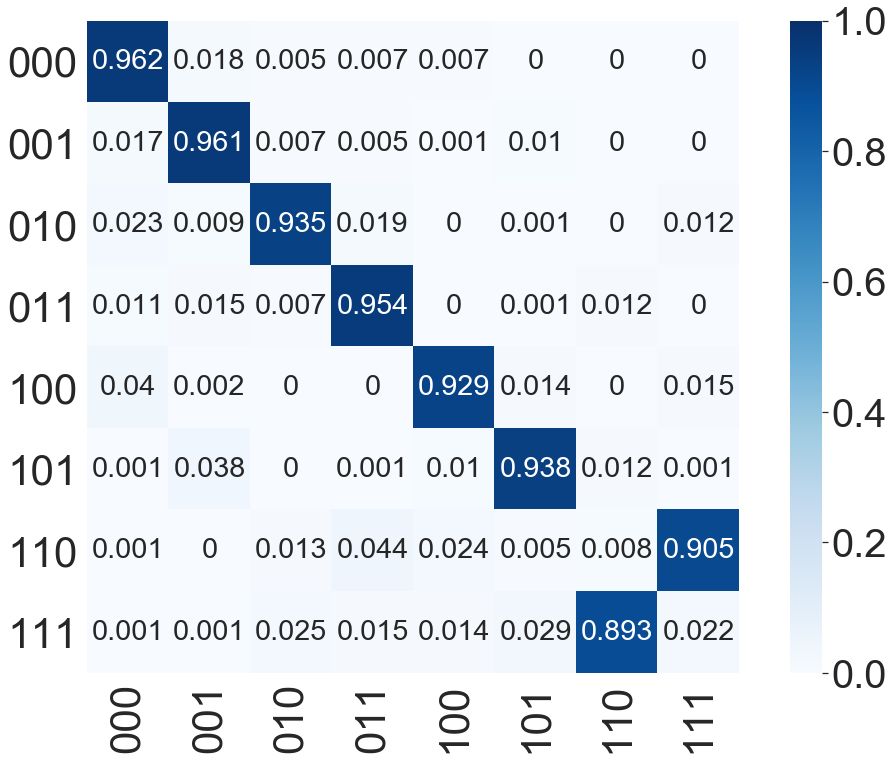

In [39]:
print("########################## R-Toffoli_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
# ## title
# plt.title("R-Toffoli_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=2.4)
sns.heatmap(mit_m_mean, 
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192]),
            fmt='g',
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=42
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=42)

plt.savefig("Rtof_m_valencia_20200106.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

########################## R-Toffoli_m ############################


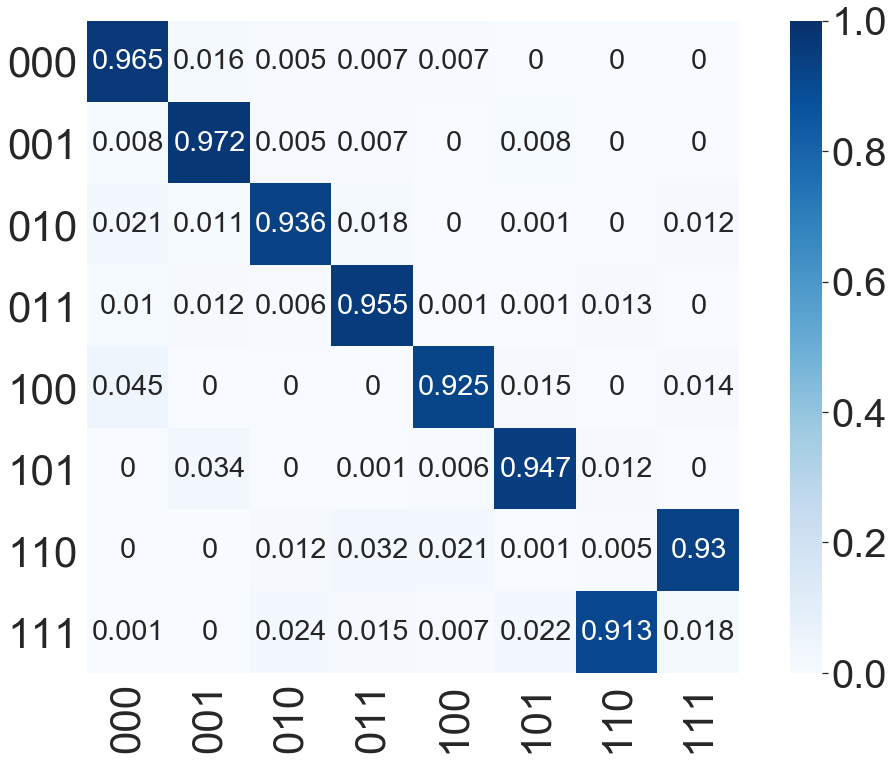

In [40]:
print("########################## R-Toffoli_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
# ## title
# plt.title("R-Toffoli_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=2.4)
sns.heatmap(mit_ix_mean, 
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192]),
            fmt='g',
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=42
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=42)

plt.savefig("Rtof_ix_valencia_20200106.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

########################## R-Toffoli_m ############################


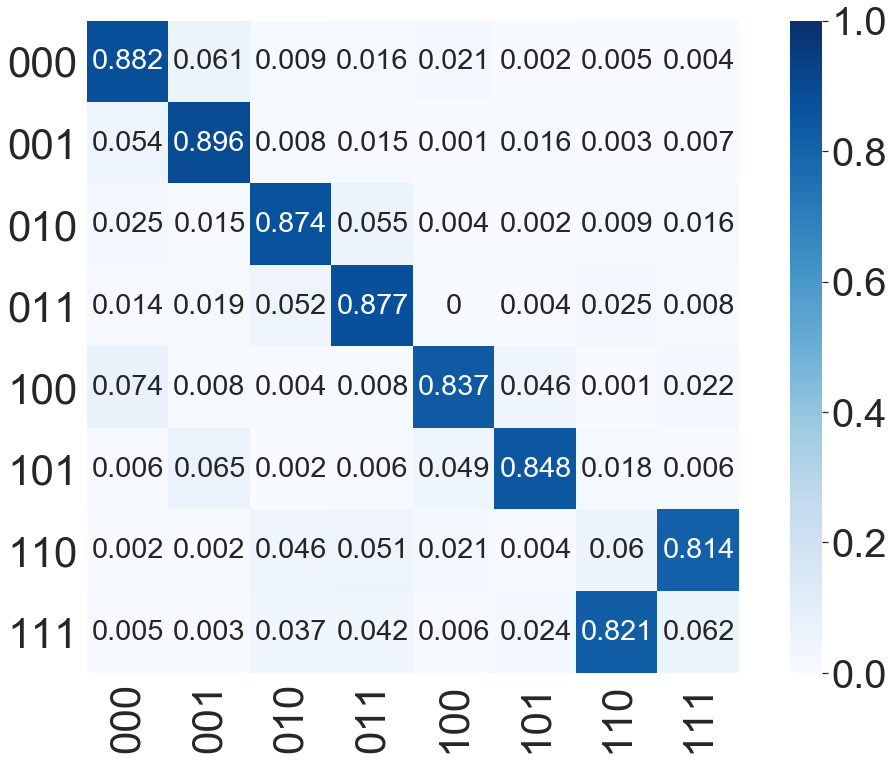

In [41]:
print("########################## R-Toffoli_m ############################")

## axix range and data labels
### axix range
length=[num+0.5 for num in range(8)]
### labels 
X = [format(num, "03b") for num in range(8)]
Y = X
#######################################################################
## set size
fig,ax = plt.subplots(figsize=(18, 12))
# ## title
# plt.title("R-Toffoli_m on "+str(device)+"\n", 
#           fontsize=20
#          )

## plot data
sns.set(font_scale=2.4)
sns.heatmap(mit_swaptof_mean, 
            vmin = 0.0,  ## define maximum value
            vmax=1,   ## defnie minimum value
            annot=True, ## show the numerical data
            square=True,  ## set heatmap to square shape
            cmap=plt.get_cmap('Blues'), ## define the color
#             cbar_kws = dict(ticks=[0, 2048, 4096, 6144, 8192]),
            fmt='g',
           )
cax = ax.collections[0].colorbar.ax # ColorbarオブジェクトからカラーバーのAxesオブジェクトにアクセス
# cax = fig.axes[-1] # これでもよい
cax.tick_params(which='minor', direction='in')
cax.tick_params(which='major', labelsize=40)

## axis
plt.xticks(length, 
           X, 
           rotation=90, 
           fontsize=42
          )
plt.yticks(length, 
           Y, 
           rotation=0, 
           fontsize=42)

plt.savefig("SWAPTof_valencia_20200106.png", dpi=200, bbox_inches="tight", pad_inches=0.1)
plt.show()

---
# Check Fidelity

In [67]:
dens_exp_m = [[col/8 for col in row] for row in mit_m_mean]
dens_sim_m = [[col/8 for col in row] for row in sim_data_m]
dens_exp_ix = [[col/8 for col in row] for row in mit_ix_mean]
dens_sim_ix = [[col/8 for col in row] for row in sim_data_ix]
dens_exp_swaptof = [[col/8 for col in row] for row in mit_swaptof_mean]
dens_sim_swaptof = [[col/8 for col in row] for row in sim_data_swaptof]

In [68]:
F_RToffoli_m_valencia_20191226 = np.trace(np.sqrt(np.dot(dens_exp_m, dens_sim_m)))
F_RToffoli_ix_valencia_20191226 = np.trace(np.sqrt(np.dot(dens_exp_ix, dens_sim_ix)))
F_swaptof_valencia_20191226 = np.trace(np.sqrt(np.dot(dens_exp_swaptof, dens_sim_swaptof)))
print("F_RToffoli_m_valencia_20191226 = ", F_RToffoli_m_valencia_20191226, "\n")
print("F_RToffoli_ix_valencia_20191226 = ", F_RToffoli_ix_valencia_20191226, "\n")
print("F_swaptof_valencia_20191226 = ", F_swaptof_valencia_20191226, "\n")

F_m =  0.9667764078393105 

F_ix =  0.9709540927721668 

F_swaptof =  0.9251925462392062 

